In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
survdata = pd.read_csv('patients_metadata.csv')
survdata = survdata[survdata['Overall_survival_days'].notna()]
survdata = survdata[survdata['Death'].notna()]
survdata.keys()

Index(['Patient_ID', 'Number_of_cores', 'Gender', 'First_diagnosis',
       'Stage_at_primary_diagnosis', 'pTu_Local', 'Histo', 'Grading',
       'Stage_TNM', 'T', 'N', 'M', 'Vascular_Invasion', 'L', 'Pn', 'OP',
       'Resection_margin_R', 'Diabetes_prior_surgery', 'ECOG', 'CA_19_9_base',
       'Date_OP', 'Description', 'Start_date_of_Adjuvant_chemo',
       'Number_of_cycles', '_Progression_date', 'Age_at_diagnosis',
       'Date_of_death_ot_last_followup', 'Progression',
       'Progression_free_survival_days', 'Overall_survival_days', 'Death'],
      dtype='object')

In [3]:
survdata = survdata[survdata["Description"]!="Acinar_cell_carcinoma"]

In [4]:
survdata.isna().sum()

Patient_ID                         0
Number_of_cores                    0
Gender                             0
First_diagnosis                    0
Stage_at_primary_diagnosis        29
pTu_Local                         36
Histo                             33
Grading                           22
Stage_TNM                         22
T                                 20
N                                 21
M                                 21
Vascular_Invasion                 26
L                                 26
Pn                                26
OP                                 1
Resection_margin_R                21
Diabetes_prior_surgery            51
ECOG                              74
CA_19_9_base                      59
Date_OP                           16
Description                       20
Start_date_of_Adjuvant_chemo      36
Number_of_cycles                  41
_Progression_date                 20
Age_at_diagnosis                  48
Date_of_death_ot_last_followup     0
P

In [5]:
outcomes = survdata[['Overall_survival_days','Death']]
features = survdata[['Gender', 'T', 'N', 'M', 'Vascular_Invasion', 'L','Pn','Resection_margin_R','Number_of_cycles', 'Age_at_diagnosis']]
#features = features.fillna(features.median().round(0).astype(int))

In [6]:
# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['Gender', 'T', 'N', 'M', 'Vascular_Invasion', 'L','Pn','Resection_margin_R','Number_of_cycles']
num_feats = ['Age_at_diagnosis']

In [7]:
from auton_survival.preprocessing import Preprocessor

preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
processed_features = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,one_hot=True, fill_value=1)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from auton_survival.models.dcm import DeepCoxMixtures

# Instantiate a DCM Model with 2 phenogroups and a single hidden layer with size 100.
model = DeepCoxMixtures(k = 2, layers = [100])
model.fit(processed_features.values, outcomes.Overall_survival_days.values, outcomes.Death.values, iters = 100, learning_rate = 1e-3)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/auton_survival/models/dcm/dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
  1%|          | 1/100 [00:00<01:21,  1.21it/s]/usr/local/lib/python3.9/site-packages/auton_survival/models/dcm/dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
 24%|██▍       | 24/100 [00:01<00:02, 34.40it/s]/usr/local/lib/python3.9/site-packages/auton_survival/models/dcm/dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
/usr/local/lib/python3.9/site-packages/auton_survival/models/dcm/dcm_utilities.py:53: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
 54%|█████▍    | 54/100 [00:01<00:01, 40.80it/s]


In [9]:
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = model.predict_latent_z(processed_features.values)

# Let's look at the latent group probabilities
latent_z_prob

# Let's look at the phenotypes
phenotypes = np.argmax(latent_z_prob, axis=1)
survdata['clusters'] = phenotypes.tolist()

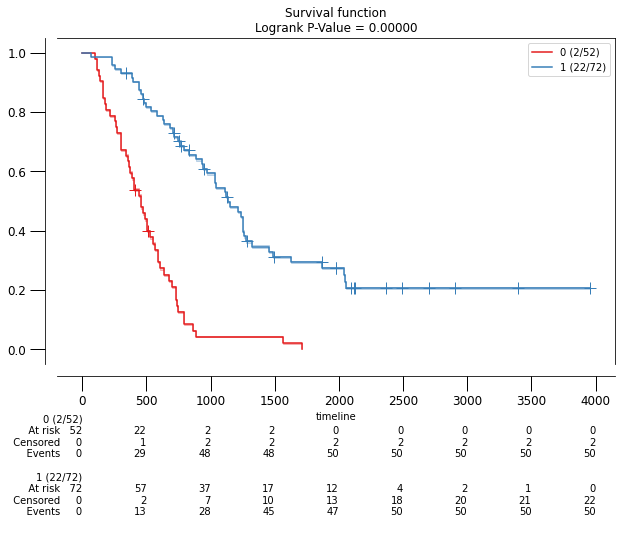

In [10]:
import kaplanmeier as km
# Plot the phenogroup specific Kaplan-Meier survival estimate.
# Compute Survival
results = km.fit(outcomes.Overall_survival_days, outcomes.Death, phenotypes)

# Plot
km.plot(results)

In [11]:
survdata.to_csv('patients_metadata_clusters.csv', sep='\t', encoding='utf-8')

In [12]:
%load_ext rpy2.ipython

In [13]:
survdata = pd.read_csv('patients_metadata_clusters.csv', sep='\t', encoding='utf-8')

In [14]:
survdata["Overall_survival_days"] = survdata["Overall_survival_days"]*0.0328767

In [15]:
%%R -i survdata -w 2 -h 2 --units in -r 300
# import df from global environment
# make default figure size 5 by 5 inches with 300 dpi resolution
library(survival)
library(survminer)
library(RColorBrewer)

km.by.os = survfit(Surv(Overall_survival_days, Death) ~ clusters, data = survdata)
summary(km.by.os)$table


R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggpubr

R[write to console]: 
Attaching package: ‘survminer’


R[write to console]: The following object is masked from ‘package:survival’:

    myeloma




           records n.max n.start events    rmean se(rmean)   median  0.95LCL
clusters=0      52    52      52     50 16.30975  1.506371 15.09041 11.96712
clusters=1      72    72      72     50 52.52895  5.423388 37.41368 31.95615
            0.95UCL
clusters=0 18.60821
clusters=1 43.56163


In [16]:
%%R -i survdata
survdiff(Surv(Overall_survival_days, Death) ~ clusters, data = survdata)

Call:
survdiff(formula = Surv(Overall_survival_days, Death) ~ clusters, 
    data = survdata)

            N Observed Expected (O-E)^2/E (O-E)^2/V
clusters=0 52       50     21.4      38.4      54.4
clusters=1 72       50     78.6      10.4      54.4

 Chisq= 54.4  on 1 degrees of freedom, p= 2e-13 


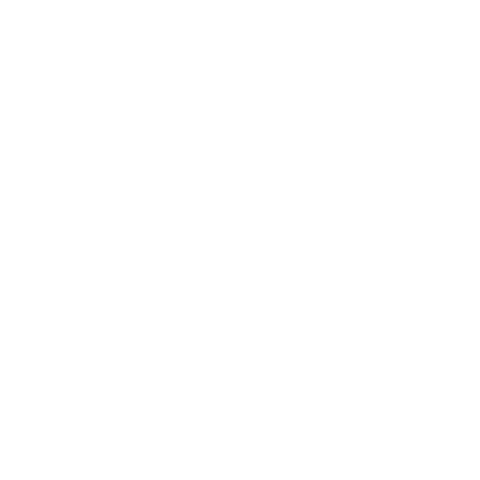

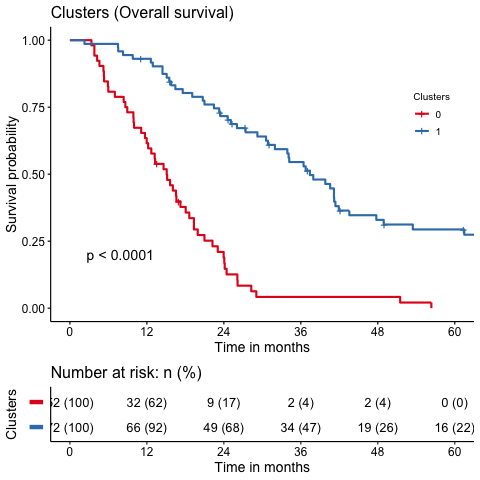

In [17]:
%%R -i survdata
p = ggsurvplot(km.by.os, 
    data = survdata, 
    pval = TRUE, 
    conf.int = FALSE, 
    xlim = c(0, 60),
    title = "Clusters (Overall survival)", 
    ylab = "Survival probability", 
    xlab = "Time in months",
    break.time.by = 12, 
    risk.table = "abs_pct", 
    risk.table.y.text.col = TRUE, 
    risk.table.y.text = FALSE,
    legend.title = "Clusters",
    legend.labs = c("0", "1"), 
    palette = brewer.pal(2,"Set1"), 
    legend = c(0.9, 0.7)
)
p

In [18]:
%%R -i survdata
save_survival_plot <- function(x, filename, width = 4, height = 4) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    svg(filename, width = width, height = height)
    grid::grid.newpage()
    grid::grid.draw(x$plot)
    dev.off()
}
save_survival_plot(p, "./survival_clusters.svg", height = 3, width = 4)

quartz_off_screen 
                2 


Fontconfig warning: ignoring UTF-8: not a valid region tag
